# Q-learning for MountainCar problem

In this notebook we will implement agent that plays MountainCar.

## About MountainCar

A car is on a one-dimensional track, positioned between two "mountains". The goal is to drive up the mountain on the right; however, the car's engine is not strong enough to scale the mountain in a single pass. Therefore, the only way to succeed is to drive back and forth to build up momentum.

Observation space is a 2-dim vector, where the 1st element represents the "car position" and the 2nd element represents the "car velocity".
There are 3 discrete deterministic actions:
- 0: Accelerate to the Left
- 1: Don't accelerate
- 2: Accelerate to the Right

<b>Reward:</b> Reward of 0 is awarded if the agent reached the flag (position = 0.5) on top of the mountain. Reward of -1 is awarded if the position of the agent is less than 0.5.

<b>Starting State:</b> The position of the car is assigned a uniform random value in [-0.6 , -0.4]. The starting velocity of the car is always assigned to 0.

<b>Episode Termination:</b> The car position is more than 0.5. Episode length is greater than 200

In [1]:
from IPython.display import Video
Video("https://gym.openai.com/videos/2019-10-21--mqt8Qj1mwo/MountainCar-v0/original.mp4")

## Step 0. Import dependencies

In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler

Constants for future usage in code. 
- <b>N</b> means number of steps in environment before terminal state (by default Gym has only 200 iterations - that's too small value for MountainCar environment)
- <b>N_EPISODES</b> means number of episodes during training. 500 episodes are enough.

In [3]:
# constants
N = 400
N_EPISODES = 200
LEARNING_RATE = 'constant'

## Step 1. Implement feature transformer

In [4]:
class FeatureTransformer:
    def __init__(self, env, n_components=100):
        obs_examples = np.asarray([env.observation_space.sample() for _ in range(10000)])
        scaler = StandardScaler()
        scaled_examples = scaler.fit_transform(obs_examples)
        self.scaler = scaler

        featurizer = FeatureUnion([
            ("rbf1", RBFSampler(gamma=5.0, n_components=n_components)),
            ("rbf2", RBFSampler(gamma=2.0, n_components=n_components)),
            ("rbf3", RBFSampler(gamma=1.0, n_components=n_components)),
            ("rbf4", RBFSampler(gamma=0.5, n_components=n_components))
        ])

        featurizer.fit_transform(scaled_examples)
        self.featurizer = featurizer

    def transform(self, X):
        X = self.scaler.transform(X)
        X = self.featurizer.transform(X)
        return X

## Step 2. Implement Model class

In [5]:
class Model:
    def __init__(self, env, learning_rate, feature_transformer):
        self.env = env
        self.models_list = []
        self.feature_transformer = feature_transformer
        # model for each action
        for _ in range(self.env.action_space.n):
            model = SGDRegressor(learning_rate=learning_rate)
            model.partial_fit(self.feature_transformer.transform([env.reset()]), [0])
            self.models_list.append(model)

    def predict(self, observation):
        observation = self.feature_transformer.transform([observation])
        prediction = np.asarray([model.predict(observation) for model in self.models_list])
        return prediction

    def sample_action(self, observation, eps):
        if np.random.random() < eps:
            action = self.env.action_space.sample()
        else:
            action = np.argmax(self.predict(observation))
        return action

    def update(self, observation, a, G):
        X = self.feature_transformer.transform([observation])
        self.models_list[a].partial_fit(X, [G])

### Step 3. Function for playing one episode

In [6]:
def play_one_episode(model,
                     env,
                     eps: float,
                     gamma: float,
                     mode: str = 'train'):
    if mode not in ['train', 'play']:
        raise ValueError("mode should be in ['train', 'play']")
    observation = env.reset()
    done = False
    total_reward = 0
    iteration = 0
    while not done:
        action = model.sample_action(observation, eps)
        prev_observation = observation
        observation, reward, done, _ = env.step(action)
        next_action = model.predict(observation)
        G = reward + gamma * np.max(next_action[0])
        if mode == 'train':                 
            model.update(prev_observation, action, G)

        total_reward += reward
        iteration += 1

    return total_reward

### Just function for tracking our learning experience.

Here we can see function for plotting running average reward during learning process.

In [7]:
def plot_running_avg(rewards):
    N = len(rewards)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = rewards[max(0, t-50):(t+1)].mean()
    plt.figure(figsize=(20, 10))
    plt.plot(running_avg)
    plt.title("Running Average")
    plt.show()

And let's do it. Now we are ready for learning. Epsilon will be decreased during learning process, so in the end we will come to ~100% decisions by our model.

In [8]:
env = gym.make('MountainCar-v0')
env._max_episode_steps = N
ft = FeatureTransformer(env)
rewards = np.empty(N_EPISODES)
model = Model(env, LEARNING_RATE, ft)
gamma = 0.99
for n in range(N_EPISODES):
    eps = 0.1 * (0.97 ** n)
    reward = play_one_episode(model, env, eps, gamma)
    rewards[n] = reward
    if (n+1) % 50 == 0:
        print(f"Iteration {n+1}")
        print(f'Last 50 iterations reward: {rewards[max(0, n-50):n].mean()}')
print(f"Total num of iterations: {rewards.sum()}")

Iteration 50
Last 50 iterations reward: -255.0204081632653
Iteration 100
Last 50 iterations reward: -140.04
Iteration 150
Last 50 iterations reward: -126.4
Iteration 200
Last 50 iterations reward: -132.86
Total num of iterations: -32617.0


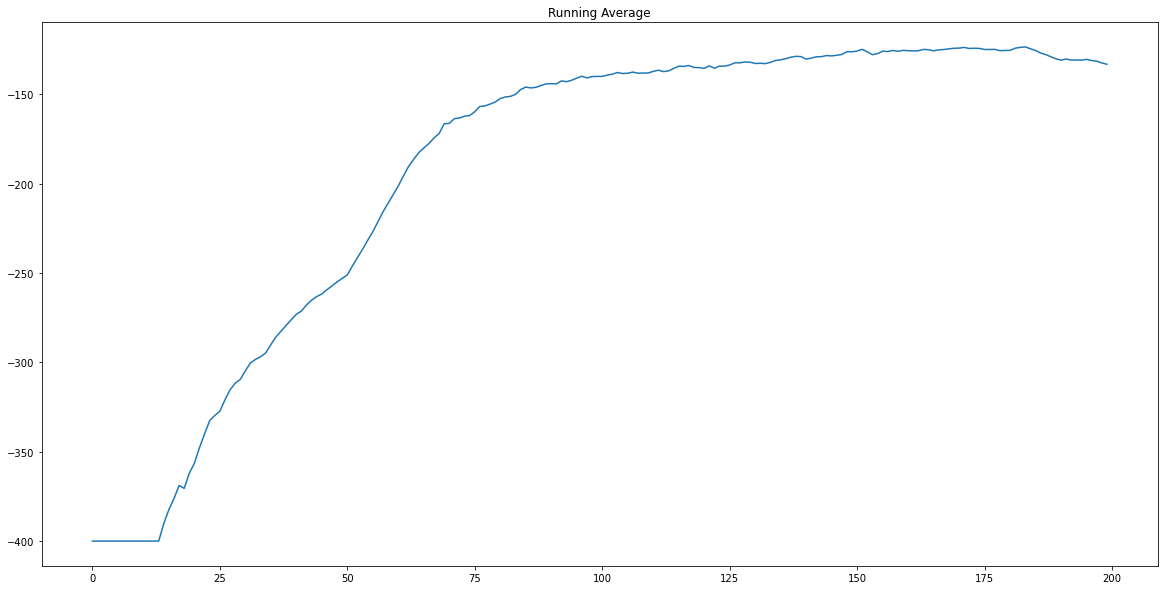

In [9]:
plot_running_avg(rewards)

In [ ]:
env = gym.wrappers.Monitor(env, './video', force=True)

In [ ]:
play_one_episode(model, env, eps=0, gamma=0.99, mode='play')